# **Lesson 5 - Advanced Analysis in MS/MS**

In this lesson, we'll learn about how we can assign peptide identifications to MS2 spectra using a database. While all lessons in this series focus on the data, previous lessons largely discussed data generation. This lesson is the first whose topic falls completely within data analysis. This lesson includes several methods where bioinformatics and algorithms made major advances for proteomics and had immediate and lasting impacts on the entire field.

## **Assumptions**

It is assumed that the reader has completed the prior lessons and is familiar with basics of biology and introductory chemistry. From the previous lessons, it is critical that you understand how and why we create MS2 spectra for peptide sequence identification (Lesson 4).

## **Goals**

At the end of this lesson, you should be able to:
- Understand the basics of database search methods for peptide sequence identification.
- Identify criteria that can be used to score possible spectrum annotations.
- Use target and decoy databases to distinguish between good and bad scores and apply a probability of correctness to an annotation.

## **Context**

In [Lesson 4](https://colab.research.google.com/drive/13WEV58HpkY7f0kFi2BA5ia5p0XZCL3Cq?usp=sharing), we learned how we can use fragment ions measured in an MS2 spectrum to infer a peptide sequence annotation for the spectrum. While we referred to the sample in Lesson 4 as "complex", the sample was composed of peptides from one protein, meaning that each MS2 spectrum had a small, finite number of sequences it could represent. Applying the correct annotation to a spectrum in this case was simple.

In reality, the goal of proteomics is to measure real-life samples like cells. These samples have thousands of different proteins, rather than a single protein. In complex samples, each MS2 spectrum could have been generated by 1 of potentially millions of distinct peptides. How do we identify what peptide is represented in a spectrum if we have orders of magnitude more options? In this lesson, we'll learn how to do this with a method called **database search**.

## **Using this Tutorial**

This tutorial is designed to be interactive, and you are encouraged to change the code and explore. To do this, you'll need to save a copy of this so that you have editing permissions. Use `File->Save a copy in Drive` to make an editable copy for yourself. Colab notebooks consist of text cells (like this one) and code cells. You interact with the notebook by executing (running) the code cells by clicking the "play button" in each cell. You can also run all cells at once by using `Runtime->Run all`.

---

## **Part 1. Installation and Setup**

Before diving into the practical aspects of advanced MS/MS analysis, let's prepare our environment by installing the necessary Python packages and defining the necessary functions. These packages will enable us to analyze and visualize MS/MS data effectively. To apply the concepts we've learned, we'll be working with real MS/MS data, so we'll be loading the data files into the Colab environment using `gdown`.

In this notebook, some code cells have been 'hidden' for brevity, like the next few below. You can recognize these because they just have a play button and a small text prompt `Show code`. In addition to the setup code, these include several functions that we will use throughout the lesson - some functions from previous lessons, some plotting code, and code to create theoretical spectra. You may want to look at this later in the lesson, but for now you can probably just click through. The first task is to establish the basic ideas behind a **database search**.

In [ ]:
# @title Run this cell to set up the coding environment, including installing and loading necessary Python packages and loading in the data files.
%%capture

!pip install gdown
!pip install pyteomics==4.6.1
!pip install plotly==5.18.0
!pip install pandas
!pip install spectrum_utils==0.4.2


import pyteomics
from pyteomics import mzml, auxiliary
import gdown
import plotly.io as pio
import plotly.tools as tls
import plotly.graph_objects as go
import pandas as pd
import random
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)

## Stream file here
!gdown 1LnRmVxOHxKZt_oeyrcuTnlfy-Asf4AUr
mzml_path = '/content/20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_21.mzML'

!gdown 1yNeczYxNKYeNwiEqR3yMZSbFb7xNbbrk
psm_path = '/content/20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_21_psm_with_decoys.tsv'

# Download the whole human proteome file
!gdown 1uLk9X7mjOeEi03lXg_pFe869vKHwS6BI
human_proteome_path = '/content/Human_proteome.fasta'

In [ ]:
# @title Run this cell to create our amino acid dictionary (from Lesson 1).
aa_mass = {'A': 71.037114, 'R':156.101111 , 'N': 114.042927,
           'D': 115.026943, 'C': 103.009185, 'E': 129.042593,
           'Q' : 128.058578, 'G': 57.021464, 'H': 137.058912,
           'I': 113.084064, 'L': 113.084064, 'K': 128.094963,
           'M' : 131.040485, 'F':  147.068414, 'P':  97.052764,
           'S': 87.032028, 'T': 101.047679, 'U': 150.95363,
           'W': 186.079313, 'Y': 163.06332, 'V': 99.068414}

In [ ]:
# @title Run this cell to declare functions that get theoretical fragment ions for a given peptide sequence.

# This will make a b/y ion ladder for any given peptide and put it in a dataframe
def make_ion_ladder(peptide, aa_mass):
    b_ions = {}
    y_ions = {}

    mass_Hydrogen = 1.0078
    mass_Oxygen = 15.994915
    proton_mass = 1.007

    '''
    Note: In the following functions, if you look closely to the calculations,
    you will see some additions of protons that are different to what we did in
    lesson 1 & 2. This is because instead of enzymatically digesting a protein,
    we are violently fragmenting the peptides milliseconds before measuring them.
    The physics is a little more complicated, so don't worry too much about it.

    If you really want to know the chemistry/physics behind this, you can read
    about it in this paper: https://cse.sc.edu/~rose/790B/papers/dancik.pdf
    '''
    # Generate b-ions
    b_mass_current = 0
    b_ion = ''
    fragment = 0
    for aa in peptide:
        b_ion += aa
        if (b_ion != peptide):
          b_mass_current += aa_mass[aa]
          b_ions[b_ion] = b_mass_current + proton_mass # mass of the charge on fragment

    # Generate y-ions
    y_mass_current = mass_Hydrogen + mass_Oxygen #adds terminal OH
    y_mass_current += proton_mass
    y_ion = ''
    fragment = 0
    for aa in peptide[::-1]:
        y_ion += aa
        if (y_ion[::-1] != peptide):
          y_mass_current += aa_mass[aa]
          y_ions[y_ion[::-1]] = y_mass_current + proton_mass #mass of charge on fragment

    # Populate dataframe
    data = {
        'b#': [b+1 for b in range(len(peptide)-1)],
        'b_ion_m/z': [b_ions[b_key] for b_key in b_ions.keys()],
        'b_ion_sequence': [b_key for b_key in b_ions.keys()],
        'y_ion_sequence': [y_key for y_key in y_ions.keys()][::-1],
        'y_ion_m/z': [y_ions[y_key] for y_key in y_ions.keys()][::-1],
        'y#': [len(peptide)-i-1 for i in range(len(peptide)-1)]
    }

    df = pd.DataFrame(data)

    return(df)

def get_theoretical_fragment_ions(peptide, aa_mass):
  theoretical_ion_ladder = make_ion_ladder(peptide, aa_mass)

  theoretical_mz = theoretical_ion_ladder["b_ion_m/z"].tolist() + theoretical_ion_ladder["y_ion_m/z"].tolist()
  theoretical_mz.sort()
  return theoretical_mz


In [ ]:
# @title Run this cell to declare a function that makes a theoretical spectrum object.

def get_theoretical_object(mz_list, precursor_mz, precursor_charge, peptide, retention_time, spectrum_id):
  su_spectrum = None
  spectrum_id = spectrum_id
  mz = mz_list
  intensity = [100 for mz in mz_list]
  retention_time = retention_time
  precursor_mz = precursor_mz
  precursor_charge = int(precursor_charge)

  su_spectrum = sus.MsmsSpectrum(spectrum_id, precursor_mz, precursor_charge, mz, intensity, retention_time=retention_time)


  # Process the spectrum
  su_spectrum = (su_spectrum.filter_intensity(0.05, 100)
                  .remove_precursor_peak(fragment_tol_mass=0.5, fragment_tol_mode='Da')
                  .scale_intensity('root'))
  # Formatting
  if su_spectrum:
      fragment_tol_mass = 0.5
      fragment_tol_mode = 'Da'  ## for some reason, if I use 'ppm' it doesn't work

      # If given the peptide, spec_utils can annotate the peaks
      if peptide:
        su_spectrum = su_spectrum.annotate_proforma(peptide, fragment_tol_mass, fragment_tol_mode, ion_types='by', max_ion_charge=2)
  return su_spectrum

In [ ]:
# @title Run this cell to declare a function that gets an MS2 spectrum object.

def get_MS2_object(mzml_path, scan, peptide = None):
    su_spectrum = None
    with pyteomics.mzml.read(mzml_path) as spectra:
        for spectrum in spectra:
            scanNumber = int(spectrum['id'].split('=')[-1])
            if scanNumber == scan:
                # This finds the corresponding values in the .mzml file to create our MS2
                spectrum_id = spectrum['id']
                mz = spectrum['m/z array']
                intensity = spectrum['intensity array']
                retention_time = spectrum['scanList']['scan'][0]['scan start time']
                precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
                precursor_charge = int(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state'])

                su_spectrum = sus.MsmsSpectrum(spectrum_id, precursor_mz, precursor_charge, mz, intensity, retention_time=retention_time)

                # Process the spectrum
                su_spectrum = (su_spectrum.filter_intensity(0.05, 100)
                               .remove_precursor_peak(fragment_tol_mass=0.5, fragment_tol_mode='Da')
                               .scale_intensity('root'))
                break
    # Formatting
    if su_spectrum:
        fragment_tol_mass = 0.5
        fragment_tol_mode = 'Da'  ## for some reason, if I use 'ppm' it doesn't work

        # If given the peptide, spec_utils can annotate the peaks
        if peptide:
          su_spectrum = su_spectrum.annotate_proforma(peptide, fragment_tol_mass, fragment_tol_mode, ion_types='by', max_ion_charge=2)
    return su_spectrum


In [ ]:
# @title Run this cell to declare a function that makes a mirror plot.
def make_mirror_plot(top_spectrum, bottom_spectrum, peptide):
  fig, ax = plt.subplots(figsize=(12, 6))
  sup.mirror(top_spectrum, bottom_spectrum, ax=ax)
  plt.title(f"Possible Sequence: {peptide}")

In [ ]:
# @title Run this cell to declare a function that pseudo-reverses a peptide.
def pseudo_reverse(peptide):
  return peptide[0:-1][::-1] + peptide[-1]

In [ ]:
# @title Run this cell to declare a function that digests an amino acid sequence into peptides with Trypsin (from Lesson 2).
def cut_with_trypsin(protein_seq, aa_mass):
  peptides = []
  peptide = ''
  for aa in protein_seq:
    peptide += aa
    if (aa == 'R' or aa == 'K'): # trypsin cuts after 'R' and 'K'
      # the peptide finishes here. Get the neutral mass and then store in the dictionary
      peptides.append(peptide)
      peptide = ''
  return peptides

In [ ]:
# @title Run this cell to declare a function that calculates the m/z values for a peptide sequence at charge states 1, 2, and 3 (from Lesson 2).

# From Lesson 1
def get_neutral_mass(peptide, aa_mass):
  neutral_mass = 0
  mass_Hydrogen = 1.0078
  mass_Oxygen = 15.994915

  neutral_mass = 0
  for aa in peptide:
    neutral_mass+=aa_mass[aa]
  neutral_mass += mass_Hydrogen #n-terminal hydrogen
  neutral_mass += (mass_Hydrogen + mass_Oxygen) #C-terminal OH
  return neutral_mass

def get_mz_vals(peptide, aa_mass):
  mass_proton = 1.007276466879
  mz_list = []
  neutral_mass = get_neutral_mass(peptide, aa_mass)
  for charge in range(1, 4):
    mz = (neutral_mass + (mass_proton*charge))/ charge
    mz_list.append(mz)
  return mz_list

## **Part 2. Spectrum Matching and Scoring**

In **Lesson 4**, we used MS2 spectra to determine what peptides were measured in our simple, one-protein experiment. In that simple experiment, we knew exactly what protein was there. However, proteomics experiments generally measure complex samples where we don't know what proteins are present. In **Lesson 4**, we showed how MS/MS measures fragments of a peptide. But the questions remain - in a complex sample, how do we know which peptides might be present? And which peptide best explains the observed spectrum?

One method is a **database search**.


Let's tackle our questions one at a time.

First, how do we know which peptides might be present? If our sample is human cells, then we can assume that the MS/MS spectrum came from a peptide in a human protein. Let's start with that. The list of all likely proteins found in a sample is called our **database**. The list of all *peptides* likely to be found in a sample is just a tryptic digestion of the protein database (see [Lesson 2](https://colab.research.google.com/drive/15cwLXSNBbVSGe1tdFB-VikMSgGXdmkKp?usp=sharing) for a reminder about tryptic digestion). It is important to note that not all of these peptides are present in the sample - the database simply limits what *may be present* in the sample.

Second, which peptide best explains the observed spectrum? If we have a list of potential peptides from the database, then we could try matching all of them against the observed spectrum and find the best. As a computational person, you are probably wondering - how do I evaluate *best*? And that is a computational/algorithmic/statistical playground! That's where we'll be today.

### A Theoretical Spectrum ###

As tandem mass spectrometry is a mature technology, we know what fragment ions to expect in MS/MS data. So we can create a theoretical MS2 spectrum for every peptide. A very basic version of this theoretical spectrum just includes the b and y ions at a uniform intensity. That's what we'll do today in this introductory lesson. Saved for a later day is the exciting machine learning task of creating more realistic spectra by predicting b/y ions and their relative intensities (see [ProteomicsML](https://proteomicsml.org/tutorials/fragmentation/) if you're interested).    

Once we have a theoretical spectrum, it can be compared to an experimental MS2 spectrum. The match between a theoretical spectrum of a peptide sequence and an observed MS2 spectrum is called a **peptide-spectrum match**, or **PSM**. Given that there are many possible matches, this lesson explores how to tell if the PSM is good - i.e., is the proposed match between a peptide sequence and a spectrum a high quality match? For the sake of simplicity, in this lesson we assume that there is at most one correct match - the peptide that was present in the sample and was isolated to create the MS2 in question.

Let's take a look at the experimental spectrum for scan number `25278` compared to several theoretical spectra for possible peptide annotations. Run the code below to produce the plots.

First, let's pull the information we need for scan `25278` out of the mzML file.

In [ ]:
our_scan = 25278

with pyteomics.mzml.read(mzml_path) as spectra:
    for spectrum in spectra:
        scanNumber = int(spectrum['id'].split('=')[-1])
        if scanNumber == our_scan:
            # This finds the corresponding values in the .mzml file
            experimental_spectrum_id = scanNumber
            experimental_retention_time = spectrum['scanList']['scan'][0]['scan start time']
            experimental_precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
            experimental_precursor_charge = int(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state'])
            # we will use these lists of fragment ion m/z values and intensities later
            experimental_fragment_mz = spectrum['m/z array']
            experimental_fragment_intensity = spectrum['intensity array']
            break

print(f"Spectrum Number: {experimental_spectrum_id}")
print(f"Retention Time: {experimental_retention_time}")
print(f"Precursor M/Z: {experimental_precursor_mz}")
print(f"Precursor Charge: {experimental_precursor_charge}")

Spectrum Number: 25278
Retention Time: 38.556908
Precursor M/Z: 554.771789550781
Precursor Charge: 2


Next, let's find tryptic peptides that match the precursor m/z and charge. These will be possible peptide sequence annotations for our spectrum. To obtain the full list of peptides, you should return to the human proteome digestion from Lesson 2. This is left as an exercise for the reader. Here, we will compare three peptide sequences for the purpose of demonstration: `NSSISGPFGSR`, `LMEAMSEVKA`, and `GMDTPAFELK`.

In [ ]:
# Feel free to use this space to digest the human proteome into tryptic peptides
# As a bonus, you could also practice calculating the masses of each of the peptides at various charge states
# and extracting a list of the ones that match the precursor m/z associated with our scan

In [ ]:
possible_peptide_annotations = ['NSSISGPFGSR', 'LMEAMSEVKA', 'GMDTPAFELK']

Finally, let's create some plots so we can choose our peptide annotation. We will be using mirror plots to visualize the spectral comparisons. For each mirror plot (we are creating one per PSM), the top half is our experimental spectrum (this will look the same for every plot) and the bottom plot shows where possible b- and y-ions would be for this peptide (refresher in **Lesson 4**).

Compare each pair of plots and decide which peptide sequence you think best matches our experimental spectrum.


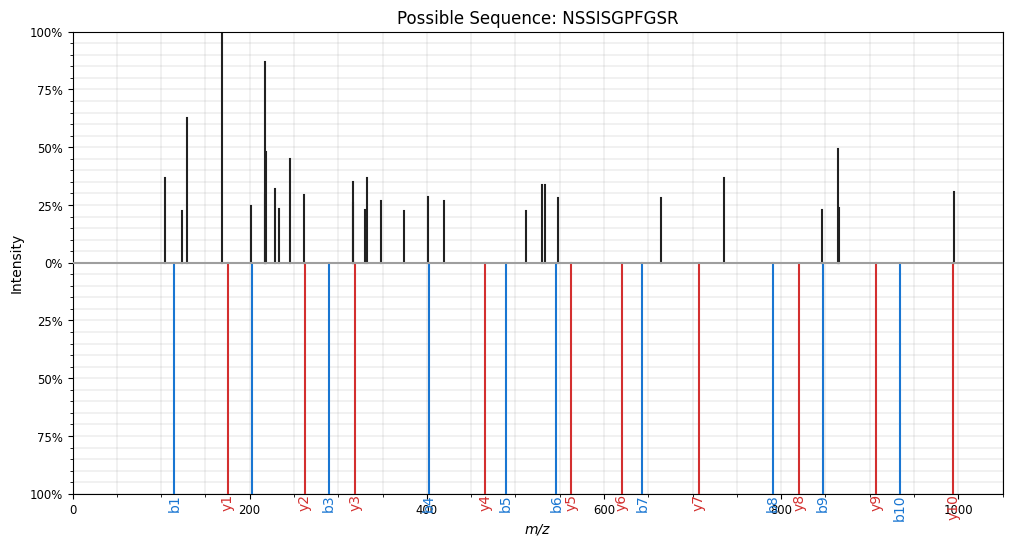

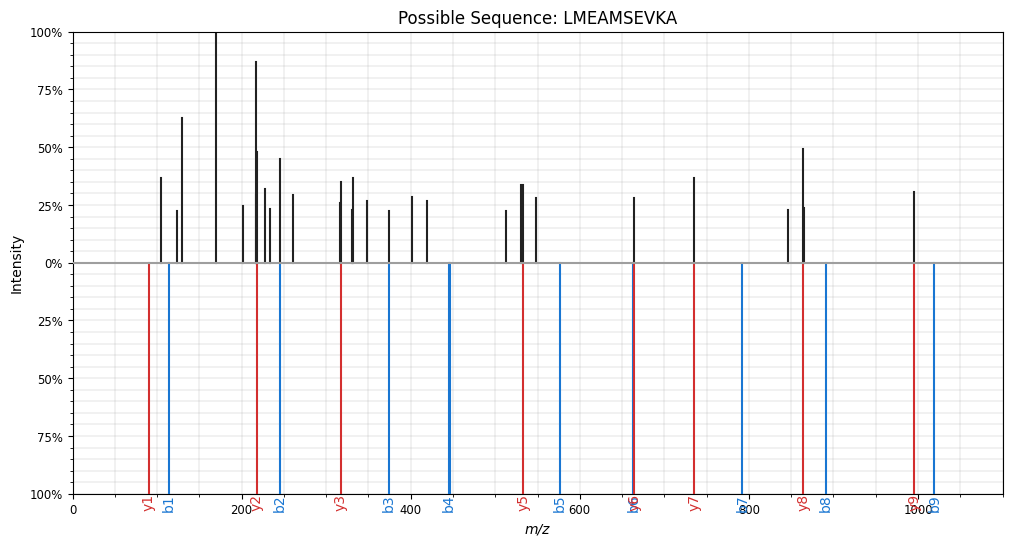

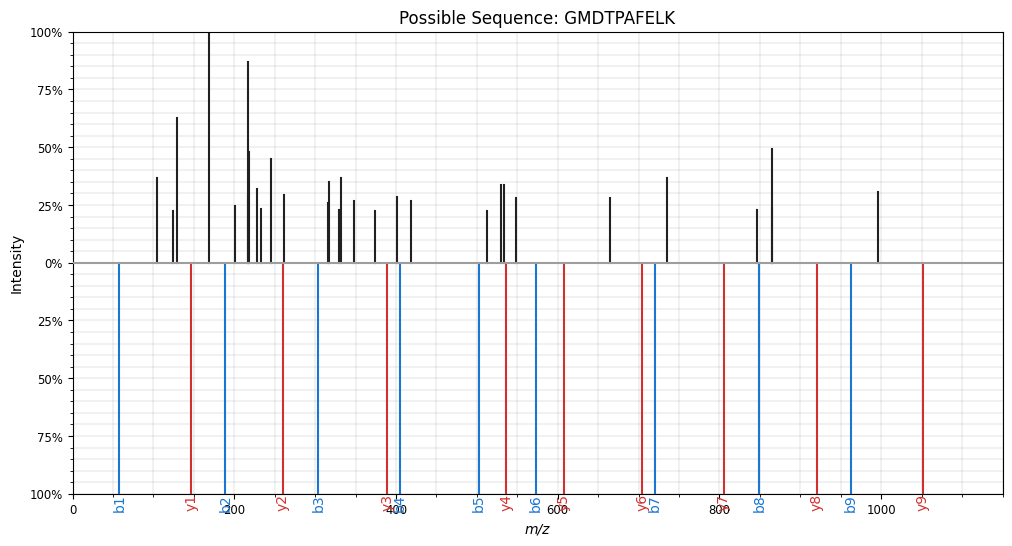

In [ ]:
# These functions are defined above in Part 1 - take a look at the code up
#   there to see what they are doing
for peptide in possible_peptide_annotations:
  experimental_spectrum = get_MS2_object(mzml_path, our_scan)
  theoretical_mz = get_theoretical_fragment_ions(peptide, aa_mass)
  theoretical_spectrum = get_theoretical_object(theoretical_mz, experimental_precursor_mz, experimental_precursor_charge, peptide, experimental_retention_time, str(experimental_spectrum_id))
  make_mirror_plot(experimental_spectrum, theoretical_spectrum, peptide)

Which peptide sequence annotation would you apply to the experimental spectrum? Why did you choose that match?

We can visually compare experimental and theoretical spectra to decide on a peptide sequence that is the best PSM. However, visually inspecting all PSMs for all MS2 spectra in an experiment (generally >100 PSMs per spectrum and >10,000 spectra per experiment) is not feasible and so … enter the computer scientists!
In order to rank PSMs, an algorithm needs to know how to compare them and how to determine if one option matches better than another. This is done by **scoring**.

There are many ways to calculate a PSM score. In this tutorial, we are going to cover basic principles of scoring and not a specific software tool or algorithm. That will be saved for a future exercise.

One simple way to generate a score for a comparison is to count the **number of matching peaks**. Let's go back to our PSMs from up above (run the code cell below to create them again if you'd like). How many m/z positions are there in each of the comparisons where there is a peak in both the experimental and theoretical spectrum? The first comparison has 3 matching peaks. If our scoring function just counted matching peaks, this would receive a score of 3. What scores would you give to the other PSMs? Is the PSM with the highest number of matching peaks the same PSM that you chose by intuition?

In [ ]:
# # This code cell recreates the same three plots from up above.
# for peptide in possible_peptide_annotations:
#   experimental_spectrum = Get_MS2_Object(mzml_path, our_scan)
#   theoretical_mz = get_theoretical_fragment_ions(peptide, aa_mass)
#   theoretical_spectrum = Get_Theoretical_Object(theoretical_mz, experimental_precursor_mz, experimental_precursor_charge, peptide, experimental_retention_time, str(experimental_spectrum_id))
#   make_mirror_plot(experimental_spectrum, theoretical_spectrum, peptide)

In [ ]:
# If you're interested in using code to count the number of matching peaks
#   for each peptide, feel free to run this cell.

# We will say a peak matches if the M/Z's match out to two decimal places.
for peptide in possible_peptide_annotations:
  theoretical_mz = [round(mz, 2) for mz in get_theoretical_fragment_ions(peptide, aa_mass)]

  num_matching_peaks = 0
  for mz in experimental_fragment_mz:
    if round(mz, 2) in theoretical_mz:
      num_matching_peaks += 1

  print(f"The number of matching peaks for {peptide} is {num_matching_peaks}.")

The number of matching peaks for NSSISGPFGSR is 3.
The number of matching peaks for LMEAMSEVKA is 10.
The number of matching peaks for GMDTPAFELK is 2.


This method of scoring clearly has limitations - what if there is a tie? What if the winner has a very few matching peaks instead of a big number like 10? What if all the matched peaks are low intensity and the non-matched peaks are high intensity? These and many other questions motivate us to describe the PSM with another score.

Instead of counting the number matching peaks, we could instead calculate a score that represents the **proportion of the matching-peak intensity** in the MS2 spectrum (i.e., $\text{the score} = \frac{\text{summed intensity of matching peaks}}{\text{total intensity}}$).

To compare the 3 PSMs from above with this idea, let's calculate scores (see code below). The total intensity for the experimental spectrum is 645.7. The amount of intensity in the matching peaks for the first comparison is around 4.22, and so this comparison would receive a score of $\text{0.0065} = \frac{\text{4.22}}{\text{645.7}}$. What scores would you give to the other PSMs? Does the PSM with the highest proportion of intensity in the matching peaks result in the same peptide sequence annotation that you chose above?

In [ ]:
# # This code cell recreates the same three plots from up above.
# for peptide in possible_peptide_annotations:
#   experimental_spectrum = Get_MS2_Object(mzml_path, our_scan)
#   theoretical_mz = get_theoretical_fragment_ions(peptide, aa_mass)
#   theoretical_spectrum = Get_Theoretical_Object(theoretical_mz, experimental_precursor_mz, experimental_precursor_charge, peptide, experimental_retention_time, str(experimental_spectrum_id))
#   make_mirror_plot(experimental_spectrum, theoretical_spectrum, peptide)

In [ ]:
# If you're interested in using code to count the proportion of matching peak intensity
#   for each peptide, feel free to run this cell.

for peptide in possible_peptide_annotations:
  theoretical_mz = [round(mz, 2) for mz in get_theoretical_fragment_ions(peptide, aa_mass)]

  total_intensity = 0
  matching_peak_intensity = 0
  max_fragment_intensity = max(experimental_fragment_intensity)
  for i, mz in enumerate(experimental_fragment_mz):
    # We are base-peak normalizing the intensities because that is how the
    #   intensities are displayed in the mirror plots
    total_intensity += (experimental_fragment_intensity[i] / max_fragment_intensity * 100)

    if round(mz, 2) in theoretical_mz:
      matching_peak_intensity += (experimental_fragment_intensity[i] / max_fragment_intensity * 100)

  proportion_matching_peak_intensity = matching_peak_intensity / total_intensity

  print(f"The total intensity for our experimental spectrum is {total_intensity}.")
  print(f"The matching peak intensity for {peptide} is {matching_peak_intensity}.")
  print(f"The proportion of matching peak intensity for {peptide} is {proportion_matching_peak_intensity}.")
  print()

The total intensity for our experimental spectrum is 645.6959297182506.
The matching peak intensity for NSSISGPFGSR is 4.217058369232513.
The proportion of matching peak intensity for NSSISGPFGSR is 0.006531028267550991.

The total intensity for our experimental spectrum is 645.6959297182506.
The matching peak intensity for LMEAMSEVKA is 127.18935537285583.
The proportion of matching peak intensity for LMEAMSEVKA is 0.19698026504264152.

The total intensity for our experimental spectrum is 645.6959297182506.
The matching peak intensity for GMDTPAFELK is 3.3023181772252976.
The proportion of matching peak intensity for GMDTPAFELK is 0.0051143549544539705.



There are many different ways a score can be calculated. The two methods we explored up above, the number of matching peaks and the proportion of matching intensity, are the two most accessible and common scoring methods. As bioinformatics scientists, a lot of time can be spent coming up with good scores, or ways to combine many scores. PSM scoring is a foundational task in proteomics and lots of people earn their career here. The best software tools often combine multiple scores with machine learning approaches to achieve the best results.

In the end, the goal of scoring is to be able to choose a winning PSM (and thereby the correct peptide annotation) for each MS2 spectrum in an experiment.

## **Part 3. Is the Winner Really the Correct Peptide?**

Now that we have a way to score potential PSMs, the question becomes: how do we know if a score is a good score or a bad score? For example, the ‘winner’ above had a score of 10 peaks or 20% explained intensity. Is that good? More importantly, does that mean that the PSM is correct? Did that spectrum really come from the peptide sequence `LMEAMSEVKA`? We need to know, because our ultimate goal is to report what we found in the sample.

Let's take a look at another set of comparisons. This time we will look at spectrum `3364`. Run the code cell below to produce the plots.

Visually, do any of these comparisons seem like a good match? Do you think one is right? Why or why not?

Spectrum Number: 3364
Retention Time: 9.030571
Precursor M/Z: 482.759613037109
Precursor Charge: 2


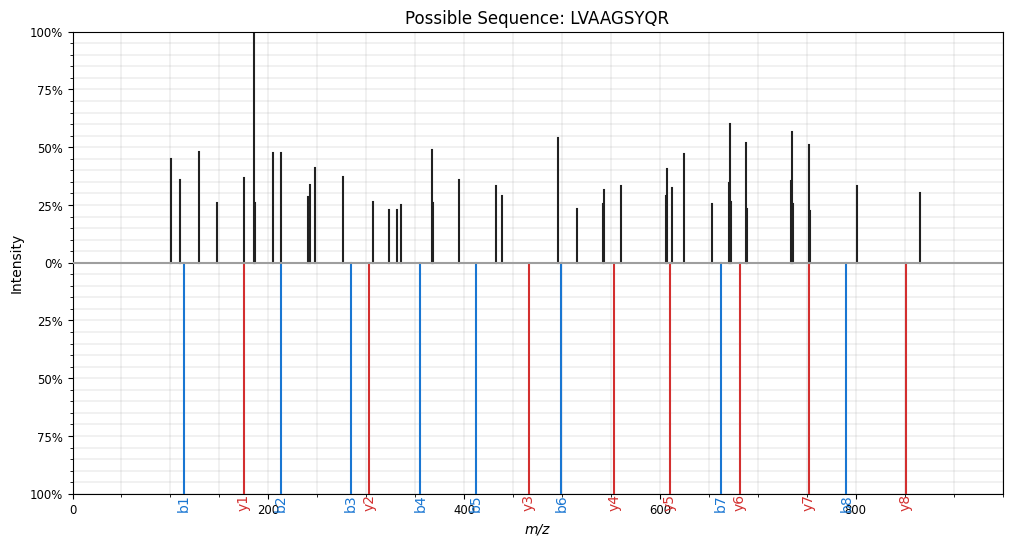

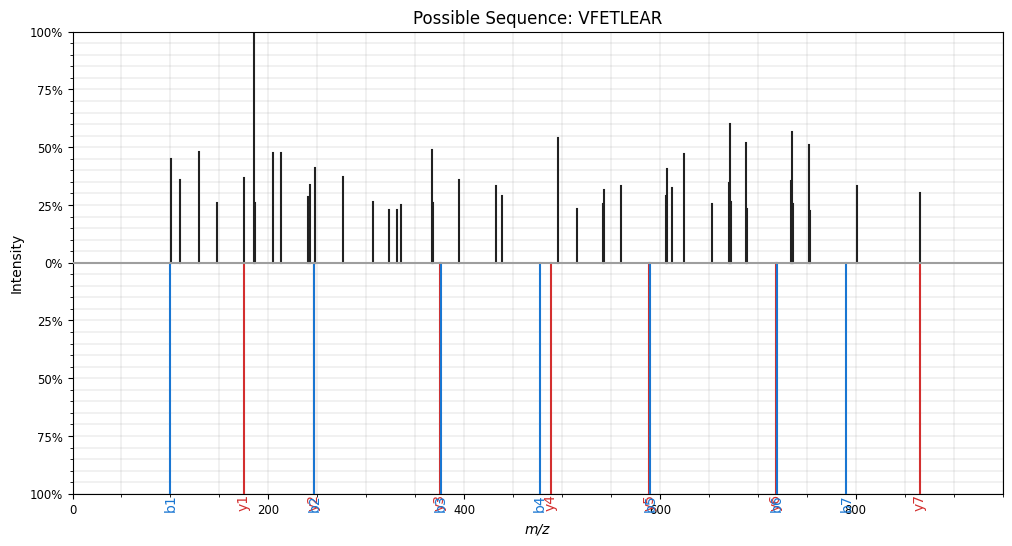

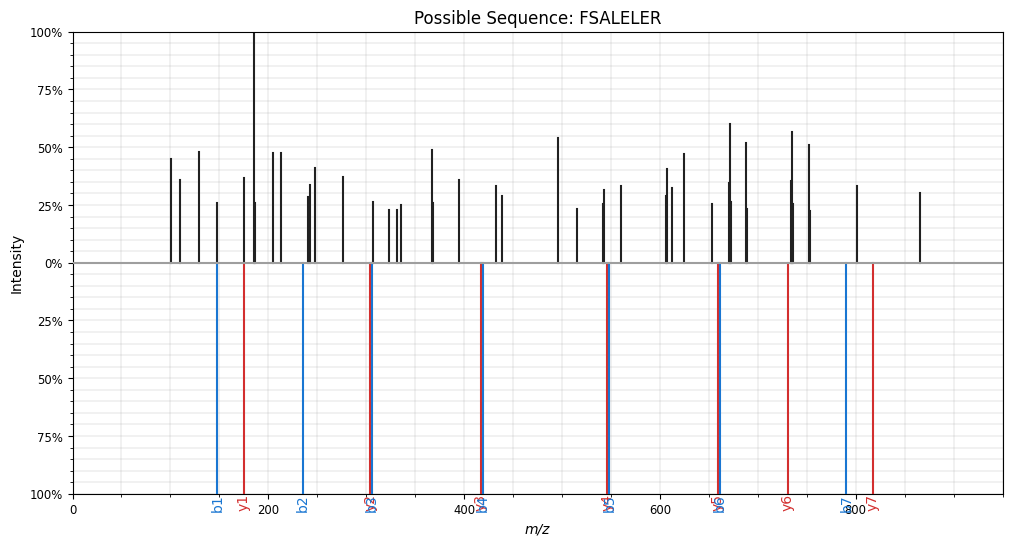

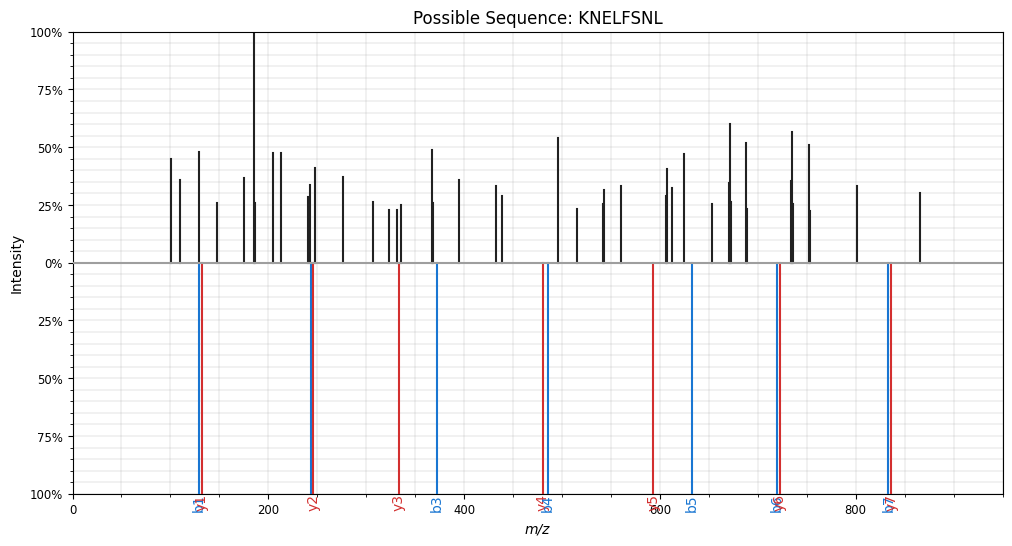

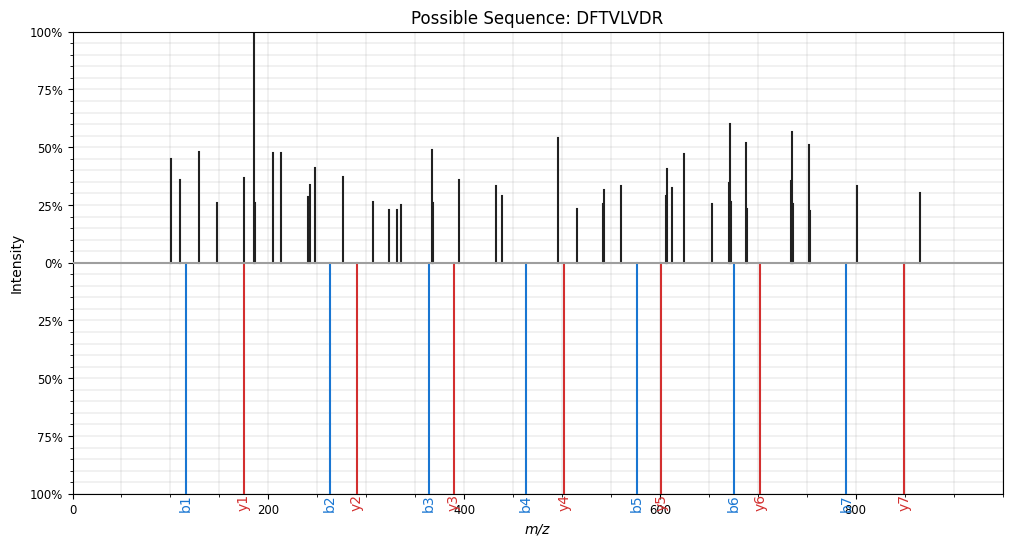

In [ ]:
our_scan = 3364

with pyteomics.mzml.read(mzml_path) as spectra:
    for spectrum in spectra:
        scanNumber = int(spectrum['id'].split('=')[-1])
        if scanNumber == our_scan:
            # This finds the cooresponding values in the .mzml file
            experimental_spectrum_id = scanNumber
            experimental_retention_time = spectrum['scanList']['scan'][0]['scan start time']
            experimental_precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
            experimental_precursor_charge = int(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state'])
            # we will use these lists of fragment ion m/z values and intensities later
            experimental_fragment_mz = spectrum['m/z array']
            experimental_fragment_intensity = spectrum['intensity array']
            break

print(f"Spectrum Number: {experimental_spectrum_id}")
print(f"Retention Time: {experimental_retention_time}")
print(f"Precursor M/Z: {experimental_precursor_mz}")
print(f"Precursor Charge: {experimental_precursor_charge}")


possible_peptide_annotations = ['LVAAGSYQR', 'VFETLEAR', 'FSALELER', 'KNELFSNL', 'DFTVLVDR']


for peptide in possible_peptide_annotations:
  experimental_spectrum = get_MS2_object(mzml_path, our_scan)
  theoretical_mz = get_theoretical_fragment_ions(peptide, aa_mass)
  theoretical_spectrum = get_theoretical_object(theoretical_mz, experimental_precursor_mz, experimental_precursor_charge, peptide, experimental_retention_time, str(experimental_spectrum_id))
  make_mirror_plot(experimental_spectrum, theoretical_spectrum, peptide)

Next, let's use scoring information to make our decision. Run the code cell below to generate the scoring details for each comparison.

Using the scoring information, what peptide sequence annotation would you apply to the experimental spectrum? Does this match with what you said up above based on a visual analysis? What might be some limitations to using a computer to make annotation decisions based solely on the highest scoring match?

In [ ]:
# Number of matching peaks
for peptide in possible_peptide_annotations:
  theoretical_mz = [round(mz, 2) for mz in get_theoretical_fragment_ions(peptide, aa_mass)]

  num_matching_peaks = 0
  for mz in experimental_fragment_mz:
    if round(mz, 2) in theoretical_mz:
      num_matching_peaks += 1

  print(f"The number of matching peaks for {peptide} is {num_matching_peaks}.")
print('\n')


# Proportion of matching peak intensity
for peptide in possible_peptide_annotations:
  theoretical_mz = [round(mz, 2) for mz in get_theoretical_fragment_ions(peptide, aa_mass)]

  total_intensity = 0
  matching_peak_intensity = 0
  max_fragment_intensity = max(experimental_fragment_intensity)
  for i, mz in enumerate(experimental_fragment_mz):
    total_intensity += (experimental_fragment_intensity[i] / max_fragment_intensity * 100)

    if round(mz, 2) in theoretical_mz:
      matching_peak_intensity += (experimental_fragment_intensity[i] / max_fragment_intensity * 100)

  proportion_matching_peak_intensity = matching_peak_intensity / total_intensity

  print(f"The total intensity for our experimental spectrum is {total_intensity}.")
  print(f"The matching peak intensity for {peptide} is {matching_peak_intensity}.")
  print(f"The proportion of matching peak intensity for {peptide} is {proportion_matching_peak_intensity}.")
  print()

The number of matching peaks for LVAAGSYQR is 2.
The number of matching peaks for VFETLEAR is 1.
The number of matching peaks for FSALELER is 1.
The number of matching peaks for KNELFSNL is 1.
The number of matching peaks for DFTVLVDR is 1.


The total intensity for our experimental spectrum is 848.6515282387338.
The matching peak intensity for LVAAGSYQR is 36.144677572196294.
The proportion of matching peak intensity for LVAAGSYQR is 0.0425907175907759.

The total intensity for our experimental spectrum is 848.6515282387338.
The matching peak intensity for VFETLEAR is 13.55048075855061.
The proportion of matching peak intensity for VFETLEAR is 0.01596707282984911.

The total intensity for our experimental spectrum is 848.6515282387338.
The matching peak intensity for FSALELER is 13.55048075855061.
The proportion of matching peak intensity for FSALELER is 0.01596707282984911.

The total intensity for our experimental spectrum is 848.6515282387338.
The matching peak intensity for KNELFS

Are you frustrated that the apparent winner is really a loser? What can we do about this?

It turns out that the correct annotation for this spectrum (which I know from the oracle) is a peptide with a post-translational modification, which is not an option we have discussed thus far. Modifications, like oxidized methionine, happen often, but are covered in a later lesson. However, among the options we did consider, there was a 'winner' from our list of candidate peptides.

Unfortunately, choosing to apply a peptide sequence annotation to an MS2 spectrum using the highest scoring PSM does not guarantee that it is correct. We can't just choose the best scoring option. We need to choose something that we believe is *correct*.

One way to begin distinguishing whether we have a "good" score or a "bad" score is to model the probability of accuracy - statistics! Statisticians love to talk about probability, often framing the problem as: what is the probability that the real answer is the null hypothesis (often called the p-value). Rephrased for us, what is the probability that the top-scoring PSM I'm looking at is wrong. We want that probability to be low, like less than 0.01.

You may be wondering, how do we know the probability that something is wrong? It would help if we had a score distribution of bad answers. Do we happen to know the score for bad PSMs?

Actually, we can model the score of incorrect PSMs and thereby calculate a statistically accurate p-value. It's an awesome proteomics method and a big historic win for bioinformatics researchers.

## **Part 4. A Null Distribution**

In statistics, creating a p-value is greatly simplified if we know the score of wrong answers. Fortunately for us, we have a method for generating wrong PSMs. This is done in proteomics with a **decoy database**.

Up above you learned about a database, something that lists the possible peptides/proteins in a sample. A decoy database contains peptides that are definitely not in the sample. They are 100% guaranteed junk. Any PSM based on these peptides is WRONG. One way to create a decoy database is to take our database of real peptides and mess up the sequence. This preserves the  precursor mass and chemical composition but also guarantees that the sequence is fake. There are lots of ways to accomplish this, but for this tutorial we'll describe the **pseudo-reverse** method.

Pseudo-reversing the peptides is done by removing the last amino acid (the tryptic end of the peptide), reversing what is left, and then adding the amino acid back to the end of the reversed peptide. This ensures that the peptides in the decoy database are also "tryptic" peptides, thus better resembling the real possible peptides.

**Below is an example of how to pseudo-reverse a peptide:**

Let's look at the peptide `SAMPLER`:
1. Remove the last amino acid --> `SAMPLE`
2. Reverse the sequence --> `ELPMAS`
3. Add the removed amino acid back on to the end of the reversed sequence -->`ELPMASR`

**Below is a coding example of how to pseudo-reverse a peptide:**

In [ ]:
# @markdown Run this cell to generate the tryptic peptides for carbonic anhydrase from **Lesson 2**.

# protein sequence
CA_protein = ('MSHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKPLALVYGEATSRRMV\
NNGHSFNVEYDDSQDKAVLKDGPLTGTYRLVQFHFHWGSSDDQGSEHTVDRKKYAAELHL\
VHWNTKYGDFGTAAQQPDGLAVVGVFLKVGDANPALQKVLDALDSIKTKGKSTDFPNFDP\
GSLLPNVLDYWTYPGSLTTPPLLESVTWIVLKEPISVSSQQMLKFRTLNFNAEGEPELLM\
LANWRPAQPLKNRQVRGFPK')

# functions to perform tryptic digestion on a protein sequence
def cut_with_trypsin(protein_seq, aa_mass):
  peptide_dict = {}
  peptide = ''
  for aa in protein_seq:
    peptide += aa
    if (aa == 'R' or aa == 'K'): # trypsin cuts after 'R' and 'K'
      # the peptide finishes here. Get the neutral mass and then store in the dictionary
      peptide_dict[peptide] = get_neutral_mass(peptide, aa_mass)
      peptide = ''
  # returns a python dictionary with string : neutral_mass pairs
  return peptide_dict

def get_neutral_mass(peptide, aa_mass):
  neutral_mass = 0
  mass_Hydrogen = 1.0078
  mass_Oxygen = 15.994915

  neutral_mass = 0
  for aa in peptide:
    neutral_mass+=aa_mass[aa]
  neutral_mass += mass_Hydrogen #n-terminal hydrogen
  neutral_mass += (mass_Hydrogen + mass_Oxygen) #C-terminal OH
  return neutral_mass


### CA protein digestion ###
CA_peptides = cut_with_trypsin(CA_protein, aa_mass)
for peptide in CA_peptides:
  print(peptide)


MSHHWGYGK
HNGPEHWHK
DFPIANGER
QSPVDIDTK
AVVQDPALK
PLALVYGEATSR
R
MVNNGHSFNVEYDDSQDK
AVLK
DGPLTGTYR
LVQFHFHWGSSDDQGSEHTVDR
K
YAAELHLVHWNTK
YGDFGTAAQQPDGLAVVGVFLK
VGDANPALQK
VLDALDSIK
TK
GK
STDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLK
EPISVSSQQMLK
FR
TLNFNAEGEPELLMLANWR
PAQPLK
NR
QVR
GFPK


In [ ]:
# @markdown Run this cell to pseudo-reverse the peptides.
# This function is defined above in Part 1 - take a look at the code up
#   there to see what it is doing
for peptide in CA_peptides:
  pseudo_reversed_peptide = pseudo_reverse(peptide)
  print(pseudo_reversed_peptide)

GYGWHHSMK
HWHEPGNHK
EGNAIPFDR
TDIDVPSQK
LAPDQVVAK
STAEGYVLALPR
R
DQSDDYEVNFSHGNNVMK
LVAK
YTGTLPGDR
DVTHESGQDDSSGWHFHFQVLR
K
TNWHVLHLEAAYK
LFVGVVALGDPQQAATGFDGYK
QLAPNADGVK
ISDLADLVK
TK
GK
LVIWTVSELLPPTTLSGPYTWYDLVNPLLSGPDFNPFDTSK
LMQQSSVSIPEK
FR
WNALMLLEPEGEANFNLTR
LPQAPK
NR
VQR
PFGK


How do we use this decoy database? We combine it with the real database, but instead of linking the peptide to its protein, we label it as 'decoy'. By using a combined database to annotate MS2 spectra, we get scores for potentially true PSMs and definite wrong PSMs.

Let's take a look at our scoring information from earlier in this section again. The "winning" peptide sequence for the experimental spectrum was `LVAAGSYQR` with a explained-intensity score of `0.043`. Let's compare this score to the score of some PSMs from the decoy sequences. Run the code cells below to create a distribution of scores for the decoy sequences.

In [ ]:
# Run this cell to create a decoy database.

# 1. Digest the human proteome like we did in an earlier lesson
# 2. Pseudo-reverse each peptide to get decoy peptides.
# 3. Calculate the mass of the decoy peptides at charges 1, 2, and 3 and round to 2 decimal places.
# 4. Store decoy database in a dictionary with rounded masses as the keys and a
#    list of tuples (PeptideSeq, Charge) as the values.

decoy_database = {}

with open(human_proteome_path) as proteome:
  header = proteome.readline().strip()
  protein = proteome.readline().strip()
  for line in proteome:
    if line.startswith('>'):
      tryptic_digest = cut_with_trypsin(protein, aa_mass)
      decoys = [pseudo_reverse(peptide) for peptide in tryptic_digest]

      for decoy in decoys:
        masses = get_mz_vals(decoy, aa_mass)

        for i, mass in enumerate(masses):
          if round(mass, 2) in decoy_database:
            decoy_database[round(mass, 2)].append((decoy, i + 1))
          else:
            decoy_database[round(mass, 2)] = [(decoy, i + 1)]

      header = line.strip()
      protein = ''
    else:
      protein += line.strip()
  else:
    tryptic_digest = cut_with_trypsin(protein, aa_mass)
    decoys = [pseudo_reverse(peptide) for peptide in tryptic_digest]

    for decoy in decoys:
      masses = get_mz_vals(decoy, aa_mass)

      for i, mass in enumerate(masses):
        if round(mass, 2) in decoy_database:
          decoy_database[round(mass, 2)].append((decoy, i + 1))
        else:
          decoy_database[round(mass, 2)] = [(decoy, i + 1)]

In [ ]:
# Run this cell to get all decoy scores. It will take 5-6 minutes.

decoy_scores = []
with pyteomics.mzml.read(mzml_path) as spectra:
    for spectrum in spectra:
      if spectrum['ms level'] > 1 and int(spectrum['id'].split('=')[-1]) % 17 == 0: #  only analyzing 1 in 17 spectra for the sake of time
          # This finds the corresponding values in the .mzml file
          spectrum_id = int(spectrum['id'].split('=')[-1])
          retention_time = spectrum['scanList']['scan'][0]['scan start time']
          precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
          precursor_charge = int(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state'])
          # we will use these lists of fragment ion m/z values and intensities later
          fragment_mz = spectrum['m/z array']
          fragment_intensity = spectrum['intensity array']

          decoys = decoy_database[round(precursor_mz, 2)] if round(precursor_mz, 2) in decoy_database else []

          for peptide in decoys:
            charge = peptide[1]
            peptide = peptide[0]
            theoretical_mz = [round(mz, 2) for mz in get_theoretical_fragment_ions(peptide, aa_mass)]

            total_intensity = 0
            matching_peak_intensity = 0
            max_fragment_intensity = max(fragment_intensity)
            for i, mz in enumerate(fragment_mz):
              total_intensity += (fragment_intensity[i] / max_fragment_intensity * 100)

              if round(mz, 2) in theoretical_mz:
                matching_peak_intensity += (fragment_intensity[i] / max_fragment_intensity * 100)

            proportion_matching_peak_intensity = matching_peak_intensity / total_intensity
            decoy_scores.append(proportion_matching_peak_intensity)

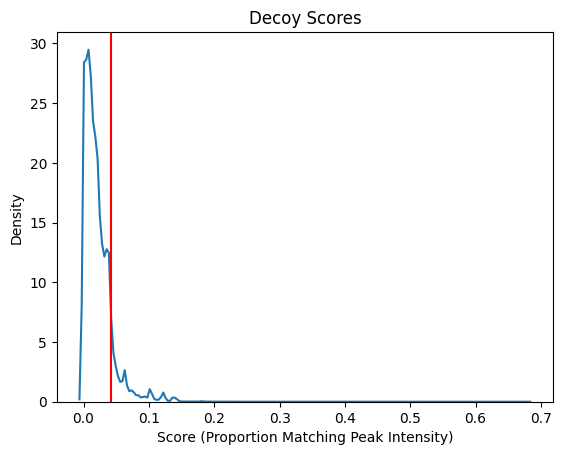

In [ ]:
# Run this cell to plot the decoy scores with a line at where our "winning" score is.
ax = sns.kdeplot(decoy_scores)
ax.set(xlabel='Score (Proportion Matching Peak Intensity)', ylabel='Density', title="Decoy Scores")
ax.axvline(x = 0.0425907175907759,
           ymin = 0,
           ymax = 1,
           color = "red")
plt.show()

The score of our "winning" PSM falls within our distribution for decoy scores, so we cannot trust this PSM. The same could be done with the 'matched peaks' score. Spoiler alert: two matched peaks is not a great score.

## **Part 5. Calculating Probabilities for Scores**

Plotting one PSM against decoys is awesome and visually powerful. However, our eventual goal is a statistically rigorous estimate on whether our PSM is correct or not. And also automation. No one wants to look at graphs all day.

A common method for calculating this probability is through **target/decoy competition**.

As a reminder, a LC-MS/MS dataset typically contains >10,000 MS2 spectra. Using database search, we will get a score for PSMs for each of these spectra. Some of the PSMs will be for peptides that come from the real database (sometimes called **target database**), and some of these PSMs will be for peptides that come from the decoy database. Above, we plotted the distribution of decoy scores (scores of known bad annotations). Now, let's add to that plot the distribution of target scores (scores of possible good answers - these are known peptides in the proteome for our sample and make up our target database).

Instead of plotting our two simplistic scores, we will transition over to the PSM output of a real software tool. This output file contains many scoring columns, and we'll choose to look at the one called `SpectralSim`. We'll also use a column with protein information telling us if the protein associated with the PSM is a target or a decoy (`Protein`).

Run the code cells below to plot a distribution for target scores and a distribution for decoy scores.

In [ ]:
# Run this cell to extract a list of target scores and a list of decoy scores from a PSM file.
psm = pd.read_csv(psm_path, sep='\t')

scores = psm['SpectralSim'].tolist()
database_ids = psm['Protein'].tolist()

target_scores = []
decoy_scores = []

for i, score in enumerate(scores):
  if database_ids[i].startswith('rev_'):
    decoy_scores.append(score)
  elif database_ids[i].startswith('sp|'):
    target_scores.append(score)

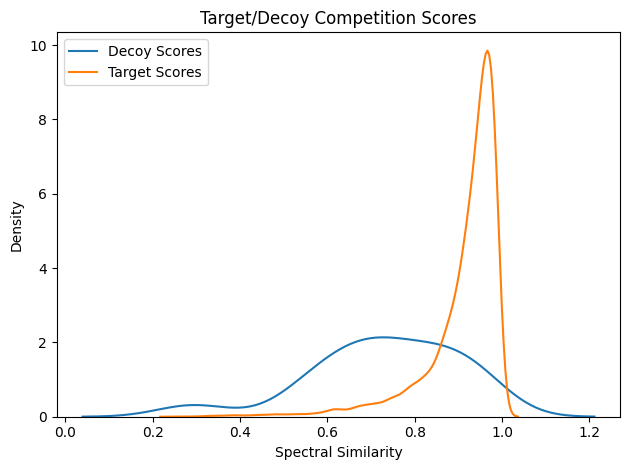

In [ ]:
# Run this cell to plot the target and decoy scores.

fig, ax = plt.subplots()
#sns.histplot(decoy_scores, label='Decoy Scores', ax=ax, binwidth=0.01, stat="density")
#sns.histplot(target_scores, label='Target Scores', ax=ax, binwidth=0.01, stat="density")
sns.kdeplot(decoy_scores, label='Decoy Scores', ax=ax)
sns.kdeplot(target_scores, label='Target Scores', ax=ax)
ax.set(xlabel='Spectral Similarity', ylabel='Density', title="Target/Decoy Competition Scores")
ax.legend()
plt.tight_layout()
plt.show()

Using the information from our target scores and our decoy scores, we can identify a statistically accurate estimate of the **false discovery rate (FDR)**. What we mean by this is, if we filter the results from our database search using a score cutoff x, what is the estimated number of PSMs scoring higher than x which are actually false-positives?

One way the FDR can be estimated is by dividing the number of decoy hits with scores at or above a chosen score threshold by the number of target hits with scores at or above that same threshold: $\text{FDR}_{score} = \frac{\text{#decoys >= score}}{\text{#targets >= score}}$.

Let's run through this with the target and decoy scores from the PSM file and a spectral similarity threshold of `0.5`.

In [ ]:
# Run this cell to calculate the FDR for a specified score threshold

annotation_score = 0.5
num_targets_score = 0
num_decoys_score = 0

for score in target_scores:
  if score >= annotation_score:
    num_targets_score += 1

for score in decoy_scores:
  if score >= annotation_score:
    num_decoys_score += 1

FDR_score = num_decoys_score / num_targets_score
FDR_score

0.002716217050435212

This tells us that among the list of PSMs that scored better than the threshold we chose (`0.5`), we expect ~0.2% of them to be incorrect. Meaning, if we had an experiment that generated 10,000 spectra and we got PSM answers for all of them, a score cutoff of `0.5` would allow a few junky PSMs in our output. FDR is one of the main methods used in proteomics today to perform quality control on the peptide annotations and filter out bad PSMs.

Now go back to the code cell above and manually edit the `annotation_score` variable. Keep making it bigger and see what happens to the false-discovery rate.

As we did with some of the earlier chemistry lessons, we'll say that there is more statistics detail here than meets the eye. There are real and meaningful differences between various statistical metrics like p-value, q-value and FDR. We are going to leave those for another day. The essential part of what we've done so far is that we show that using decoy PSMs can help us estimate the accuracy of a PSM from the target database.

## **Part 6. A Look at Real Output**

In the previous section, we pulled some information out of a PSM file. This file is the output of a database search program and has all of the scoring and probability information associated with the mzML file we've been using, both of which come from a real LC-MS/MS experiment. Now that we understand database search, PSM scoring, and probabilities, let's take a look at the real PSM output file. We read in the file earlier in this lesson and stored the table in a variable called `psm`.

In [ ]:
psm

,Spectrum,Spectrum File,Peptide,Modified Peptide,Extended Peptide,Prev AA,Next AA,Peptide Length,Charge,Retention,Observed Mass,Calibrated Observed Mass,Observed M/Z,Calibrated Observed M/Z,Calculated Peptide Mass,Calculated M/Z,Delta Mass,SpectralSim,RTScore,Expectation,Hyperscore,Nextscore,PeptideProphet Probability,Number of Enzymatic Termini,Number of Missed Cleavages,Protein Start,Protein End,Intensity,Assigned Modifications,Observed Modifications,Purity,Is Unique,Protein,Protein ID,Entry Name,Gene,Protein Description,Mapped Genes,Mapped Proteins
0,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,TKGPLKQK,NaN,RATEKSVK.TKGPLKQK.QPSFSAKK,K,Q,8,2,316.9380,898.5608,898.5615,450.2877,450.2880,898.5600,450.2873,0.0015,0.9060,1.9724,1.185768e-01,13.204,0.000,0.9979,2,2,77,84,0.0,NaN,NaN,0.0,True,sp|O95997|PTTG1_HUMAN,O95997,PTTG1_HUMAN,PTTG1,Securin,NaN,NaN
1,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,RKEEEEAEDK,NaN,KEEEEDKK.RKEEEEAEDK.EDDEDKDE,K,E,10,3,317.8086,1261.5791,1261.5800,421.5336,421.5339,1261.5785,421.5334,0.0014,0.4481,7.7971,1.557312e+00,9.150,0.000,0.5055,2,2,376,385,0.0,NaN,NaN,0.0,True,sp|P27797|CALR_HUMAN,P27797,CALR_HUMAN,CALR,Calreticulin,NaN,NaN
2,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,HQPHKVTQYKK,NaN,TFCKKCGK.HQPHKVTQYKK.GKDSIYAQ,K,G,11,3,318.7554,1392.7637,1392.7631,465.2618,465.2616,1392.7626,465.2615,0.0004,0.9018,10.1405,1.418562e-02,24.016,10.095,1.0000,2,2,18,28,0.0,NaN,NaN,0.0,False,sp|P83881|RL36A_HUMAN,P83881,RL36A_HUMAN,RPL36A,60S ribosomal protein L36a,RPL36AL,sp|Q969Q0|RL36L_HUMAN
3,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,HPAHPMR,NaN,AVVQIKPR.HPAHPMR.GRIPIIAV,R,G,7,2,318.8823,844.4123,844.4125,423.2135,423.2135,844.4126,423.2136,-0.0001,0.8709,2.4172,2.049981e-03,22.253,11.506,0.9959,2,0,935,941,0.0,NaN,NaN,0.0,True,sp|Q15149|PLEC_HUMAN,Q15149,PLEC_HUMAN,PLEC,Plectin,NaN,NaN
4,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,QPVGGGQK,NaN,VKPAAAPK.QPVGGGQK.LITRKADS,K,L,8,2,319.0129,769.4084,769.4086,385.7115,385.7116,769.4082,385.7114,0.0004,0.9399,3.0569,1.790606e-01,14.488,10.668,0.9803,2,0,408,415,0.0,NaN,NaN,0.0,True,sp|Q14978|NOLC1_HUMAN,Q14978,NOLC1_HUMAN,NOLC1,Nucleolar and coiled-body phosphoprotein 1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,SLTNDWEDHLAVK,NaN,EEYGEFYK.SLTNDWEDHLAVK.HFSVEGQI,K,H,13,3,3901.5542,1526.7397,1526.7382,509.9205,509.9200,1526.7365,509.9194,0.0017,0.8590,123.2011,1.967887e-04,24.324,8.891,0.5969,2,0,307,319,0.0,NaN,NaN,0.0,False,sp|P08238|HS90B_HUMAN,P08238,HS90B_HUMAN,HSP90AB1,Heat shock protein HSP 90-beta,HSP90AA1,sp|P07900|HS90A_HUMAN
16439,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,SYELPDGQVITIGNER,NaN,ASSSSIEK.SYELPDGQVITIGNER.FRCPEAIF,K,F,16,2,3921.3171,1789.8896,1789.8885,895.9521,895.9515,1789.8845,895.9495,0.0040,0.9737,118.6509,3.388100e-09,29.442,8.863,0.9973,2,0,239,254,0.0,NaN,NaN,0.0,False,sp|P63261|ACTG_HUMAN,P63261,ACTG_HUMAN,ACTG1,"Actin, cytoplasmic 2","ACTA1, ACTA2, ACTB, ACTBL2, ACTC1, ACTG2, POTE...","sp|A5A3E0|POTEF_HUMAN, sp|P60709|ACTB_HUMAN, s..."
16440,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_...,C:\Users\Isengard\MassSpec\Team_Alyssa_Champio...,DSLLQDGEFSMDLR,NaN,GQKCSVIR.DSLLQDGEFSMDLR.TKSTGGAP,R,T,14,2,3929.5771,1624.7443,1624.7383,813.3794,813.3764,1624.7402,813.3774,-0.0019,0.9397,101.8626,1.178284e-03,22.215,0.000,0.9807,2,0,76,89,0.0,NaN,NaN,0.0,True,sp|P07737|PROF1_HUMAN,P07737,PROF1_HUMAN,PFN1,Profilin-1,NaN,NaN
16441,20150708_QE3_UPLC8_DBJ_SA_Hela_39frac_Trypsin_.

You'll notice that this file has A LOT going on, so let's break it down.

Each row represents a specific PSM - the data about a match between a peptide sequence and an MS/MS spectrum.

- The first column, `Spectrum` contains information on the file and spectrum number for the spectrum in that PSM.
- The third column, `Peptide`, contains the peptide sequence in that PSM. It is also possible for a peptide to be modified (covered in more detail in later lessons), so there is another column indicating whether or not the peptide is modified as well.
- If you scroll further right in the table, you'll see information you're familiar with from the mzML like retention time, m/z, and charge.
- Past those columns (starting with the `Delta Mass` column and going through the `Nextscore`) are columns containing information used in scoring PSMs. You should note that there are *a lot* of columns for scoring. There are many different ways to describe the PSM, all of which contribute towards an overall picture of quality. The specific analysis tool we used was [FragPipe](https://fragpipe.nesvilab.org/).
- The next column is called `PeptideProphet Probability` and represents the "probability of correctness" for the PSM. FragPipe calculates their probability slightly differently than we did above, and in this case the higher the `PeptideProphet Probability` score, the more confident the PSM is.
- The rest of the columns contain information about the protein identified using that PSM, including some of the protein's chemical properties and information about identifiers that can be used to find it in databases such as [UniProt](https://www.uniprot.org/).

For more information on this output file, visit the documentation about the file from the tool [here](https://fragpipe.nesvilab.org/docs/tutorial_fragpipe_outputs.html#psmtsv).

## **Conclusion**

The goal of this lesson is to describe the process of peptide identification in complex samples. Most of the time, we know the set of possible proteins from our sample and we gather these into a **database**. From the database, we generate a list of tryptic peptides and their m/z. When looking through MS/MS spectra in an LC-MS/MS dataset, we match possible candidate peptides against a spectrum. This peptide-spectrum match, or **PSM**, is scored according to a variety of metrics. Then, to determine the likelihood that the PSM is correct, we estimate the **false discovery rate** using a set of decoy PSMs.

The process described above is typically encapsulated in a database search software program. Many such programs exist, and improving on this method is a very common research task for bioinformatics and data scientists.

## **Lesson 5 Terms**

* **database**: the list of all likely proteins found in a sample; the database is digested *in silico* to get the list of all likely peptides in a sample
* **database search**: a method used to apply peptide sequence annotations to MS2 spectra; theoretical spectra are created for sequences in a database, compared to the experimental spectra, and scored to choose these annotations
* **peptide-spectrum match (PSM)**: the comparison of a peptide sequence to an MS2 spectrum
* **scoring**: a metric used by an algorithm to rank and choose the best PSM per experimental spectrum; *number of matching peaks* and *proportion of matching-peak intensity* are two examples of scoring methods
* **number of matching peaks**: the number of peaks in an experimental spectrum that have matching m/z values to peaks in a theoretical spectrum
* **proportion of matching-peak intensity**: the summed intensity of peaks in the experimental spectrum that have matching m/z values to peaks in the theoretical spectrum divided by the total intensity in the experimental spectrum; $\text{the score} = \frac{\text{summed intensity of matching peaks}}{\text{total intensity}}$
* **target database**: a list of peptide sequences that could possibly be part of the sample; this comes from digesting the database
* **decoy database**: a list of peptide sequences that cannot possibly be part of the sample; one method for creating a decoy database is *pseudo-reverse*
* **pseudo-reverse**: a method for creating decoy sequences for a decoy database; for each peptide sequence in the target database, (1) remove the last amino acid, (2) reverse what is left of the peptide, and (3) add the removed amino acid back on to the end of the reversed peptide
* **target/decoy competition**: a method of database search that uses a concatenated database of target and decoy sequences to search against; PSMs that match decoy peptides are decoy (or bad) hits and PSMs that match target peptides are target (or good) hits
* **false-discovery rate (FDR)**: the number of decoy hits with scores at or above a chosen threshold divided by the number of target hits with scores at or above the same threshold; $\text{FDR}_{score} = \frac{\text{#decoys >= score}}{\text{#targets >= score}}$
